训练集大小: 23923
测试集大小: 5981
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.312977	valid's rmse: 0.32766
[200]	train's rmse: 0.30348	valid's rmse: 0.322573
[300]	train's rmse: 0.296628	valid's rmse: 0.319455
[400]	train's rmse: 0.29189	valid's rmse: 0.318077
[500]	train's rmse: 0.287783	valid's rmse: 0.316786
[600]	train's rmse: 0.284257	valid's rmse: 0.31574
[700]	train's rmse: 0.281045	valid's rmse: 0.315177
[800]	train's rmse: 0.278199	valid's rmse: 0.314512
[900]	train's rmse: 0.275873	valid's rmse: 0.314216
Early stopping, best iteration is:
[948]	train's rmse: 0.274797	valid's rmse: 0.314116

✅ 模型训练完成！最佳迭代轮数: 948


D:\python\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



========== 模型评估结果 ==========
对数空间 - RMSE: 0.3141, R²: 0.6544
原始价格空间 - RMSE: 2.05 万元/㎡
原始价格空间 - MAPE: 24.88%


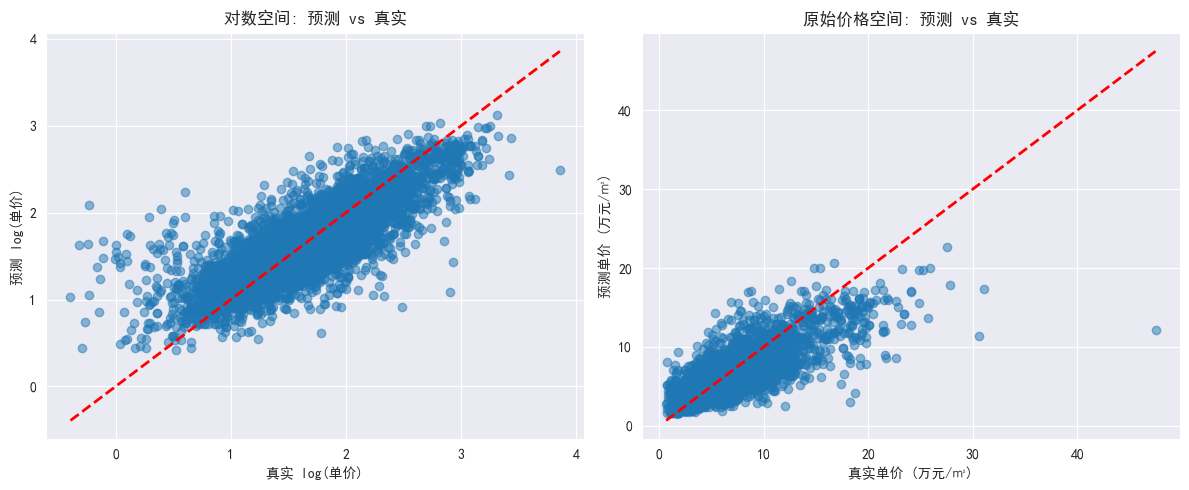

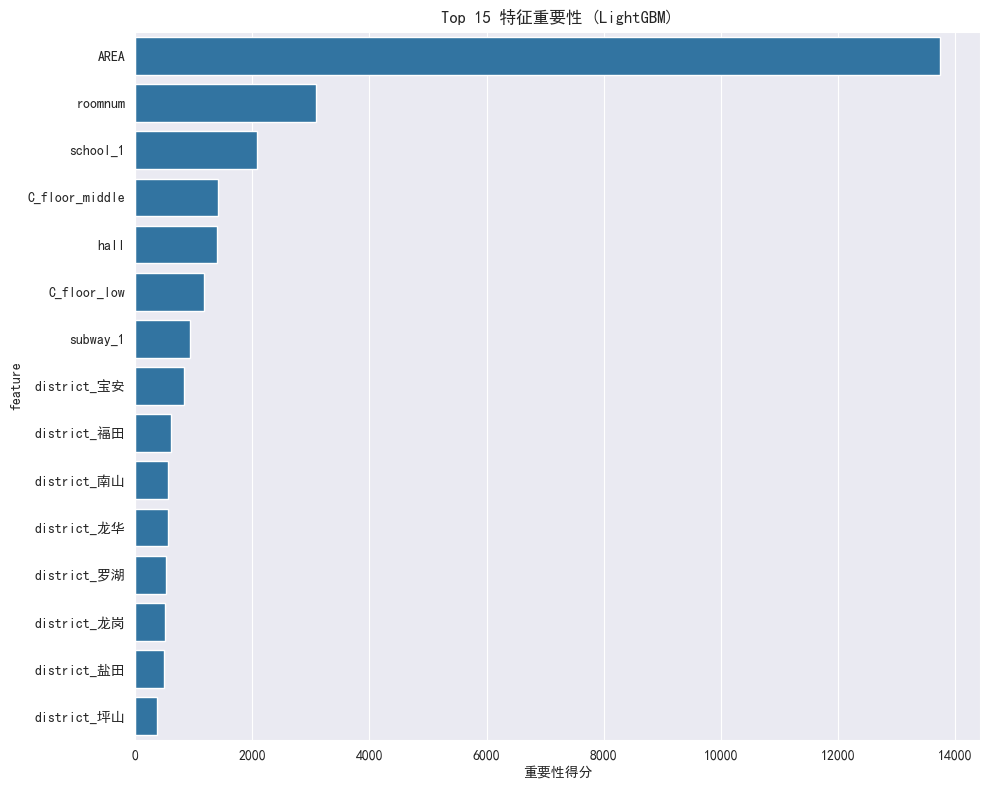


========== Top 10 重要特征 ==========
           feature  importance
0             AREA       13733
1          roomnum        3093
15        school_1        2075
13  C_floor_middle        1424
2             hall        1392
12     C_floor_low        1171
14        subway_1         930
6      district_宝安         833
8      district_福田         621
3      district_南山         562

✅ 模型已保存为 'house_price_model_lgb.pkl'

✅ 示例：预测一套南山80㎡三房的价格
预测单价: 4.70 万元/平方米
预测总价 (80㎡): 376 万元


D:\python\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [8]:
# ======================================
# =============================================================================
# 第一步：导入库 & 加载数据
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import joblib
import matplotlib

# 设置中文字体（Windows）
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

# 加载清洗后数据
df = pd.read_excel(r'E:\shenzhen_house_price_project\data\clean\清洗后数据.xlsx')

# =============================================================================
# 第二步：构造目标变量（基于EDA结论）
# =============================================================================
df['log_per_price'] = np.log(df['per_price'])
y = df['log_per_price']

# =============================================================================
# 第三步：定义特征
# =============================================================================
num_features = ['AREA', 'roomnum', 'hall']
cat_features = ['district', 'C_floor', 'subway', 'school']
all_features = num_features + cat_features

# 检查列是否存在
missing_cols = [col for col in all_features if col not in df.columns]
if missing_cols:
    raise ValueError(f"缺失列: {missing_cols}")

X = df[all_features].copy()

# =============================================================================
# 第四步：划分训练集/测试集（按区域分层）
# =============================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['district']
)

print(f"训练集大小: {X_train.shape[0]}")
print(f"测试集大小: {X_test.shape[0]}")

# =============================================================================
# 第五步：构建预处理管道
# =============================================================================
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
    ],
    remainder='drop'
)

# =============================================================================
# 第六步：构建并训练 LightGBM 模型（✅ 修正版）
# =============================================================================
# 先拟合预处理器以获取转换后的数据（用于 eval_set）
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 初始化模型（不包含 early_stopping_rounds）
regressor = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.05,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    random_state=42,
    n_estimators=1000,
    verbose=-1  # 静默主日志
)

# 使用 callbacks 实现早停和日志
from lightgbm import early_stopping, log_evaluation

regressor.fit(
    X_train_processed, y_train,
    eval_set=[(X_train_processed, y_train), (X_test_processed, y_test)],
    eval_names=['train', 'valid'],
    callbacks=[
        early_stopping(stopping_rounds=50, verbose=True),
        log_evaluation(period=100)  # 每100轮打印一次
    ]
)

# 组装完整 Pipeline（用于后续预测）
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

print(f"\n✅ 模型训练完成！最佳迭代轮数: {regressor.best_iteration_}")

# =============================================================================
# 第七步：模型评估
# =============================================================================
y_pred_log = model_pipeline.predict(X_test)
y_test_orig = np.exp(y_test)
y_pred_orig = np.exp(y_pred_log)

rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
r2_log = r2_score(y_test, y_pred_log)
rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mape_orig = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100

print("\n========== 模型评估结果 ==========")
print(f"对数空间 - RMSE: {rmse_log:.4f}, R²: {r2_log:.4f}")
print(f"原始价格空间 - RMSE: {rmse_orig:.2f} 万元/㎡")
print(f"原始价格空间 - MAPE: {mape_orig:.2f}%")

# =============================================================================
# 第八步：可视化预测效果
# =============================================================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_log, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('真实 log(单价)')
plt.ylabel('预测 log(单价)')
plt.title('对数空间: 预测 vs 真实')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_test_orig, y_pred_orig, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
plt.xlabel('真实单价 (万元/㎡)')
plt.ylabel('预测单价 (万元/㎡)')
plt.title('原始价格空间: 预测 vs 真实')
plt.grid(True)

plt.tight_layout()
plt.show()

# =============================================================================
# 第九步：特征重要性分析
# =============================================================================
ohe = model_pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(cat_features)
feature_names = num_features + list(cat_feature_names)

importances = model_pipeline.named_steps['regressor'].feature_importances_
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feat_imp_df.head(15), x='importance', y='feature')
plt.title('Top 15 特征重要性 (LightGBM)')
plt.xlabel('重要性得分')
plt.tight_layout()
plt.show()

print("\n========== Top 10 重要特征 ==========")
print(feat_imp_df.head(10))

# =============================================================================
# 第十步：保存模型
# =============================================================================
joblib.dump(model_pipeline, 'house_price_model_lgb.pkl')
print("\n✅ 模型已保存为 'house_price_model_lgb.pkl'")

# =============================================================================
# 第十一步：模型使用示例（✅ 无警告预测）
# =============================================================================
print("\n✅ 示例：预测一套南山80㎡三房的价格")

new_sample = pd.DataFrame({
    'AREA': [80],
    'roomnum': [3],
    'hall': [2],
    'district': ['南山'],
    'C_floor': ['middle'],
    'subway': [1],
    'school': [1]
})

# 直接用 Pipeline 预测（自动处理编码，无特征名警告）
log_pred = model_pipeline.predict(new_sample)
price_pred = np.exp(log_pred[0])

print(f"预测单价: {price_pred:.2f} 万元/平方米")
print(f"预测总价 (80㎡): {price_pred * 80:.0f} 万元")